# Import Libraries

In [90]:
!python --version

Python 3.10.12


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('max_colwidth', None)
pd.set_option("display.max_columns", None)

In [ ]:
!pip uninstall xgboost
!pip install xgboost==0.90


Found existing installation: xgboost 2.0.3
Uninstalling xgboost-2.0.3:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/xgboost-2.0.3.dist-info/*
    /usr/local/lib/python3.10/dist-packages/xgboost.libs/libgomp-a34b3233.so.1.0.0
    /usr/local/lib/python3.10/dist-packages/xgboost/*
Proceed (Y/n)? Y
  Successfully uninstalled xgboost-2.0.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 MB 2.7 MB/s eta 0:00:00


In [29]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

from imblearn.over_sampling import SMOTE, ADASYN

In [4]:
# !pip install gensim

In [ ]:
# !pip install zeugma

In [ ]:
# !pip install fasttext

In [36]:
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

# First steps

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Import Cleaned CSV file
file_path = '/content/drive/MyDrive/Capstone/DataSet_Cleaned_Descriptions.csv'
df = pd.read_csv(file_path)

In [ ]:
df.head()


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   Unnamed: 0                   425 non-null    int64   
 1   Date                         425 non-null    object  
 2   Country                      425 non-null    object  
 3   Local                        425 non-null    object  
 4   Industry_Sector              425 non-null    object  
 5   Accident_Level               425 non-null    category
 6   Potential_Accident_Level     425 non-null    object  
 7   Gender                       425 non-null    object  
 8   Employee_type                425 non-null    object  
 9   Critical_Risk                425 non-null    object  
 10  Description                  425 non-null    object  
 11  Cleaned_Description          425 non-null    object  
 12  Original_Description_Length  425 non-null    int64   
 13  Clean

In [10]:
df['Accident_Level'] = df['Accident_Level'].astype('category')
df['Accident_Level'].cat.reorder_categories(['I', 'II', 'III', 'IV', 'V'], ordered=True)

0       I
1       I
2       I
3       I
4      IV
       ..
420     I
421     I
422     I
423     I
424     I
Name: Accident_Level, Length: 425, dtype: category
Categories (5, object): ['I' < 'II' < 'III' < 'IV' < 'V']

In [30]:
#Another approach to treat target variable
df['Level'] = df["Accident_Level"].replace({'I':1 , 'II':2, 'III':3, 'IV':4,'V':5})
df['Accident_Level']

0      0
1      0
2      0
3      0
4      3
      ..
420    0
421    0
422    0
423    0
424    0
Name: Accident_Level, Length: 425, dtype: int64

In [28]:
#Another approach to treat target variable
from sklearn.preprocessing import LabelEncoder
#Encode Target Variable
le=LabelEncoder()
df['Accident_Level']=le.fit_transform(df['Accident_Level'])


Accident_Level
0    316
1     40
2     31
3     30
4      8
Name: count, dtype: int64

In [12]:
df['Accident_Level'].value_counts()

Accident_Level
I      316
II      40
III     31
IV      30
V        8
Name: count, dtype: int64

In [ ]:
# y_text = LabelEncoder().fit_transform(y_text)
# y_text = np_utils.to_categorical(y_text)


# X = df["Cleaned_Description"]
# Y = df["Accident_Level"]
# Y = df["Accident_Level"].map({'I':1 , 'II':2, 'III':3, 'IV':4,'V':5})

# **Model Building**

In [13]:
#Function to plot the confusion matrix
def plot_confusion_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize = (5, 4))
    label_list = ['I','II','III','IV','V']
    sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = label_list, yticklabels = label_list)
    plt.ylabel('Actual Accident Level')
    plt.xlabel('Predicted Accident Level')
    plt.show()

In [14]:
#Function to print the metrics
def print_Metrics(y_train, y_pred_train, y_test, y_pred_test):
  print("Confusion Matrix for Training Data")
  plot_confusion_matrix(y_train, y_pred_train)
  print("\nConfusion Matrix for Testing Data")
  plot_confusion_matrix(y_test, y_pred_test)
  print("Classification Report for Training Data")
  print(classification_report(y_train,y_pred_train))
  print("Classification Report for Testing Data")
  print(classification_report(y_test,y_pred_test))
  #Accuracy
  train_accuracy = accuracy_score(y_train,y_pred_train)
  print("Training Accuracy: ", round(train_accuracy*100, 2))
  test_accuracy = accuracy_score(y_test,y_pred_test)
  print("Testing Accuracy: ", round(test_accuracy*100, 2))
  f1 = f1_score(y_test, y_pred_test, average="weighted")
  print("F1 score:", round(f1*100, 2))

In [15]:
#Function to run the corresponding models
def Execute_model(X_train, y_train, X_test, y_test, model):
  match model:
        case 'LR':
            model = LogisticRegression(multi_class="multinomial", solver="lbfgs")
        case 'RFC':
            model = RandomForestClassifier(n_estimators=100, max_depth=5)
        case 'SVM':
            model = SVC(gamma=0.025, C=3)
        case 'XGB':
            model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, gamma=0, objective="multi:softprob", eval_metric='mlogloss'  )

  model.fit(X_train, y_train)
  # Predicting on train data
  y_pred_train = model.predict(X_train)
  # Predicting on test data
  y_pred_test = model.predict(X_test)
  #Calls function to display metrics
  print_Metrics(y_train, y_pred_train, y_test, y_pred_test)

**Oversampling with SMOTE and ADASYN**

Functions to create Training and Test sets using the oversampling techniques

In [52]:
def create_SMOTE_Xy(X_train, y_train):
  # Define the SMOTE oversampler
  smote = SMOTE(sampling_strategy='auto')

  # Apply SMOTE to the training data
  X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

  print("Shape of Training and Test sets after SMOTE operation")
  print(X_train_smote.shape,y_train_smote.shape,X_test.shape, y_test.shape)

  return X_train_smote, y_train_smote

In [53]:
def create_ADASYN_Xy(X_train, y_train):
  # Define the ADASYN oversampler
  adasyn = ADASYN(sampling_strategy='auto')

  # Apply ADASYN to the training data
  X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

  print("Shape of Training and Test sets after ADASYN operation")
  print(X_train_adasyn.shape,y_train_adasyn.shape,X_test.shape, y_test.shape)

  return X_train_adasyn, y_train_adasyn

# **Embeddings**

## **Word2Vec**

In [16]:
# Creating a list of all words in our data
words_list = [item.split(" ") for item in df['Cleaned_Description'].values]
# Creating an instance of Word2Vec
vec_size = 300
model_W2V = Word2Vec(words_list, vector_size = vec_size, min_count = 1, window=5, workers = 6)
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(list(model_W2V.wv.key_to_index)))

Length of the vocabulary is 1925


In [17]:
# Checking top 5 similar words to the word
similar1 = model_W2V.wv.similar_by_word('crash', topn=5)
print(similar1)

[('blow', 0.3988994359970093), ('ramp', 0.39743879437446594), ('projection', 0.3924787640571594), ('hospital', 0.3902158737182617), ('unit', 0.3898349702358246)]


In [134]:
similar2 = model_W2V.wv.similar_by_word('spill', topn=5)
print(similar2)

[('edge', 0.7959553003311157), ('ladder', 0.7939923405647278), ('pipe', 0.7939451336860657), ('slip', 0.792708158493042), ('mechanic', 0.7924871444702148)]


**Observation**

The embeddings look are doing a good job of capturing contextual information

In [18]:
# Retrieving the words present in the Word2Vec model's vocabulary
words = list(model_W2V.wv.key_to_index.keys())

# Retrieving word vectors for all the words present in the model's vocabulary
wvs = model_W2V.wv[words].tolist()

# Creating a dictionary of words and their corresponding vectors
word_vector_dict = dict(zip(words, wvs))

In [19]:
def average_vectorizer_Word2Vec(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [20]:
# creating a dataframe of the vectorized documents for the Cleaned Description
df_Word2Vec = pd.DataFrame(df['Cleaned_Description'].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
df_Word2Vec


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,Feature 10,Feature 11,Feature 12,Feature 13,Feature 14,Feature 15,Feature 16,Feature 17,Feature 18,Feature 19,Feature 20,Feature 21,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29,Feature 30,Feature 31,Feature 32,Feature 33,Feature 34,Feature 35,Feature 36,Feature 37,Feature 38,Feature 39,Feature 40,Feature 41,Feature 42,Feature 43,Feature 44,Feature 45,Feature 46,Feature 47,Feature 48,Feature 49,Feature 50,Feature 51,Feature 52,Feature 53,Feature 54,Feature 55,Feature 56,Feature 57,Feature 58,Feature 59,Feature 60,Feature 61,Feature 62,Feature 63,Feature 64,Feature 65,Feature 66,Feature 67,Feature 68,Feature 69,Feature 70,Feature 71,Feature 72,Feature 73,Feature 74,Feature 75,Feature 76,Feature 77,Feature 78,Feature 79,Feature 80,Feature 81,Feature 82,Feature 83,Feature 84,Feature 85,Feature 86,Feature 87,Feature 88,Feature 89,Feature 90,Feature 91,Feature 92,Feature 93,Feature 94,Feature 95,Feature 96,Feature 97,Feature 98,Feature 99,Feature 100,Feature 101,Feature 102,Feature 103,Feature 104,Feature 105,Feature 106,Feature 107,Feature 108,Feature 109,Feature 110,Feature 111,Feature 112,Feature 113,Feature 114,Feature 115,Feature 116,Feature 117,Feature 118,Feature 119,Feature 120,Feature 121,Feature 122,Feature 123,Feature 124,Feature 125,Feature 126,Feature 127,Feature 128,Feature 129,Feature 130,Feature 131,Feature 132,Feature 133,Feature 134,Feature 135,Feature 136,Feature 137,Feature 138,Feature 139,Feature 140,Feature 141,Feature 142,Feature 143,Feature 144,Feature 145,Feature 146,Feature 147,Feature 148,Feature 149,Feature 150,Feature 151,Feature 152,Feature 153,Feature 154,Feature 155,Feature 156,Feature 157,Feature 158,Feature 159,Feature 160,Feature 161,Feature 162,Feature 163,Feature 164,Feature 165,Feature 166,Feature 167,Feature 168,Feature 169,Feature 170,Feature 171,Feature 172,Feature 173,Feature 174,Feature 175,Feature 176,Feature 177,Feature 178,Feature 179,Feature 180,Feature 181,Feature 182,Feature 183,Feature 184,Feature 185,Feature 186,Feature 187,Feature 188,Feature 189,Feature 190,Feature 191,Feature 192,Feature 193,Feature 194,Feature 195,Feature 196,Feature 197,Feature 198,Feature 199,Feature 200,Feature 201,Feature 202,Feature 203,Feature 204,Feature 205,Feature 206,Feature 207,Feature 208,Feature 209,Feature 210,Feature 211,Feature 212,Feature 213,Feature 214,Feature 215,Feature 216,Feature 217,Feature 218,Feature 219,Feature 220,Feature 221,Feature 222,Feature 223,Feature 224,Feature 225,Feature 226,Feature 227,Feature 228,Feature 229,Feature 230,Feature 231,Feature 232,Feature 233,Feature 234,Feature 235,Feature 236,Feature 237,Feature 238,Feature 239,Feature 240,Feature 241,Feature 242,Feature 243,Feature 244,Feature 245,Feature 246,Feature 247,Feature 248,Feature 249,Feature 250,Feature 251,Feature 252,Feature 253,Feature 254,Feature 255,Feature 256,Feature 257,Feature 258,Feature 259,Feature 260,Feature 261,Feature 262,Feature 263,Feature 264,Feature 265,Feature 266,Feature 267,Feature 268,Feature 269,Feature 270,Feature 271,Feature 272,Feature 273,Feature 274,Feature 275,Feature 276,Feature 277,Feature 278,Feature 279,Feature 280,Feature 281,Feature 282,Feature 283,Feature 284,Feature 285,Feature 286,Feature 287,Feature 288,Feature 289,Feature 290,Feature 291,Feature 292,Feature 293,Feature 294,Feature 295,Feature 296,Feature 297,Feature 298,Feature 299
0,-0.003605,0.015140,0.000537,0.004516,0.002058,-0.014036,0.008622,0.037599,-0.000073,-0.005674,-0.001468,-0.014009,0.001457,-0.000015,-0.009434,-0.009528,0.004790,-0.001790,0.011665,-0.007122,-0.010133,0.000708,0.010564,0.001291,0.010566,-0.000181,-0.024638,-0.000448,-0.009542,-0.015296,0.003462,-0.009841,0.001194,0.003934,-0.003751,0.006651,0.001169,-0.018764,0.000280,-0.000477,-0.007978,0.001730,-0.001756,-0.008845,0.010331,0.020164,0.008044,0.005086,-0.002637,0.014391,0.008132,0.006170,-0.002498,0.00

In [21]:
# Storing independent variable
X = df_Word2Vec.copy()

# Storing target variable
y = df["Accident_Level"]
y = df["Accident_Level"].map({'I':1 , 'II':2, 'III':3, 'IV':4,'V':5})

X_train, X_test, y_train, y_test = train_test_split(X ,y, test_size = 0.20, random_state = 42, stratify = y)

X_train.shape,y_train.shape,X_test.shape, y_test.shape

((340, 300), (340,), (85, 300), (85,))

In [22]:
X_train_smote, y_train_smote = create_SMOTE_Xy(X_train, y_train)

((1265, 300), (1265,), (85, 300), (85,))

In [23]:
X_train_adasyn, y_train_adasyn = create_ADASYN_Xy(X_train, y_train)

((1287, 300), (1287,), (85, 300), (85,))

### **Random Forest using Word2Vec**

We shall use these Word2Vec embeddings on Random Forest Classifiers for 3 cases
- Unbalanced
-Oversampling with SMOTE
-Oversampling with ADASYN

**Unbalanced Data**

Confusion Matrix for Training Data


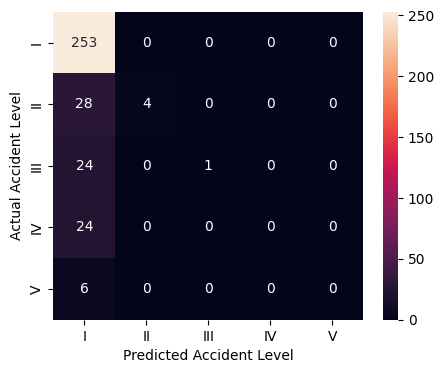


Confusion Matrix for Testing Data


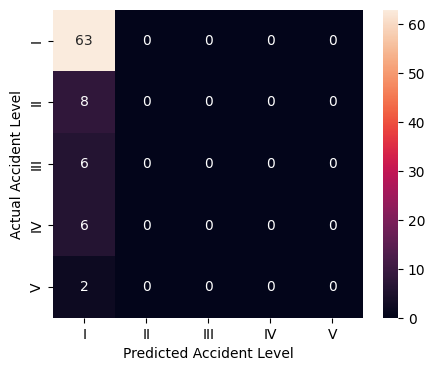

Classification Report for Training Data
              precision    recall  f1-score   support

           I       0.76      1.00      0.86       253
          II       1.00      0.12      0.22        32
         III       1.00      0.04      0.08        25
          IV       0.00      0.00      0.00        24
           V       0.00      0.00      0.00         6

    accuracy                           0.76       340
   macro avg       0.55      0.23      0.23       340
weighted avg       0.73      0.76      0.67       340

Classification Report for Testing Data
              precision    recall  f1-score   support

           I       0.74      1.00      0.85        63
          II       0.00      0.00      0.00         8
         III       0.00      0.00      0.00         6
          IV       0.00      0.00      0.00         6
           V       0.00      0.00      0.00         2

    accuracy                           0.74        85
   macro avg       0.15      0.20      0.17        8

In [136]:
Execute_model(X_train, y_train, X_test, y_test, model='RFC')

**Observations**

It is evident that the model performs poorly on minority classes owing to lack of adequate training data because of the highly imbalanced dataset.

We shall try some oversampling techniques to fix this problem.

**Using SMOTE to balance the data**

Confusion Matrix for Training Data


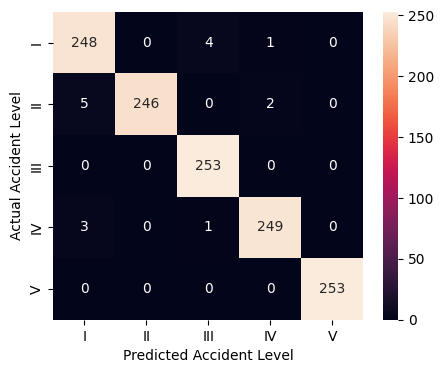


Confusion Matrix for Testing Data


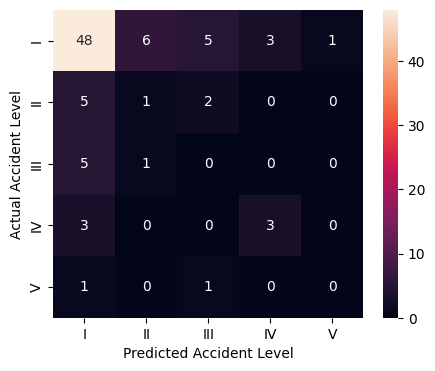

Classification Report for Training Data
              precision    recall  f1-score   support

           I       0.97      0.98      0.97       253
          II       1.00      0.97      0.99       253
         III       0.98      1.00      0.99       253
          IV       0.99      0.98      0.99       253
           V       1.00      1.00      1.00       253

    accuracy                           0.99      1265
   macro avg       0.99      0.99      0.99      1265
weighted avg       0.99      0.99      0.99      1265

Classification Report for Testing Data
              precision    recall  f1-score   support

           I       0.77      0.76      0.77        63
          II       0.12      0.12      0.12         8
         III       0.00      0.00      0.00         6
          IV       0.50      0.50      0.50         6
           V       0.00      0.00      0.00         2

    accuracy                           0.61        85
   macro avg       0.28      0.28      0.28        8

In [139]:
Execute_model(X_train_smote , y_train_smote, X_test, y_test, model='RFC')

**Observations**

We have used SMOTE to balance the data

The model overfits on training data but performance reduces on testing data

The performance on minority classes is still lacking

**Using ADASYN to balance the data**

Confusion Matrix for Training Data


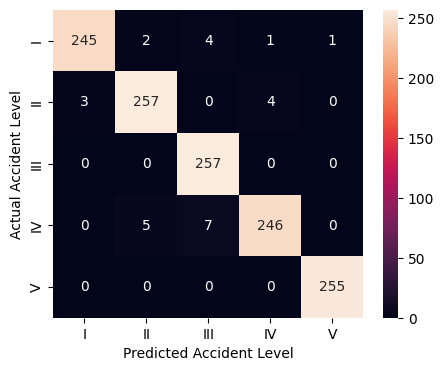


Confusion Matrix for Testing Data


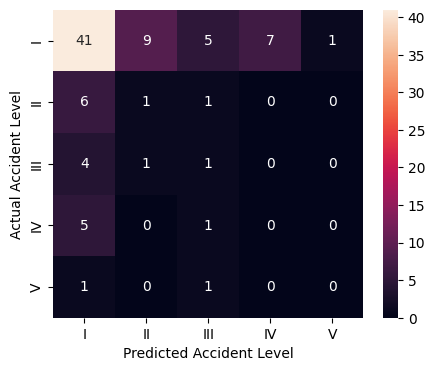

Classification Report for Training Data
              precision    recall  f1-score   support

           I       0.99      0.97      0.98       253
          II       0.97      0.97      0.97       264
         III       0.96      1.00      0.98       257
          IV       0.98      0.95      0.97       258
           V       1.00      1.00      1.00       255

    accuracy                           0.98      1287
   macro avg       0.98      0.98      0.98      1287
weighted avg       0.98      0.98      0.98      1287

Classification Report for Testing Data
              precision    recall  f1-score   support

           I       0.72      0.65      0.68        63
          II       0.09      0.12      0.11         8
         III       0.11      0.17      0.13         6
          IV       0.00      0.00      0.00         6
           V       0.00      0.00      0.00         2

    accuracy                           0.51        85
   macro avg       0.18      0.19      0.18        8

In [142]:
Execute_model(X_train_adasyn, y_train_adasyn, X_test, y_test, model='RFC')

**Observations**

We have used ADASYN to balance the data in this case

The model overfits on training data but performance is reduced on testing data

The performance on minority classes is still lacking

The performance of the model when oversampling using SMOTE and ADASYN is almost similar

### **SVM using Word2Vec**

We shall use these Word2Vec embeddings on Support Vector Classifiers for 3 cases
- Unbalanced
-Oversampling with SMOTE
-Oversampling with ADASYN

**Unbalanced Data**

Confusion Matrix for Training Data


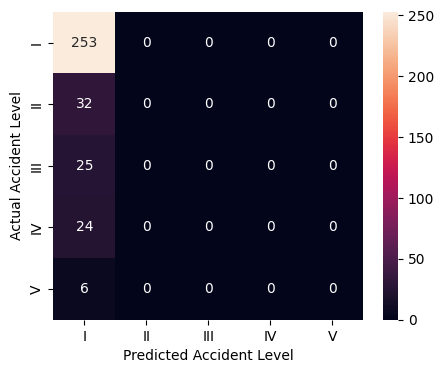


Confusion Matrix for Testing Data


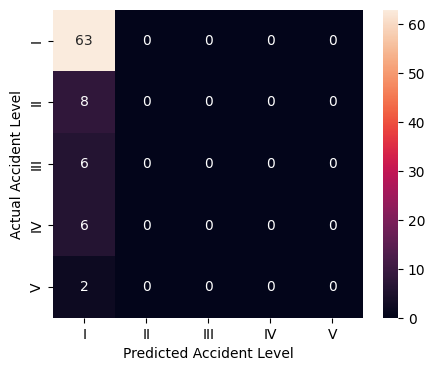

Classification Report for Training Data
              precision    recall  f1-score   support

           I       0.74      1.00      0.85       253
          II       0.00      0.00      0.00        32
         III       0.00      0.00      0.00        25
          IV       0.00      0.00      0.00        24
           V       0.00      0.00      0.00         6

    accuracy                           0.74       340
   macro avg       0.15      0.20      0.17       340
weighted avg       0.55      0.74      0.63       340

Classification Report for Testing Data
              precision    recall  f1-score   support

           I       0.74      1.00      0.85        63
          II       0.00      0.00      0.00         8
         III       0.00      0.00      0.00         6
          IV       0.00      0.00      0.00         6
           V       0.00      0.00      0.00         2

    accuracy                           0.74        85
   macro avg       0.15      0.20      0.17        8

In [144]:
Execute_model(X_train, y_train, X_test, y_test, model='SVM')

**Using SMOTE to balance the data**

Confusion Matrix for Training Data


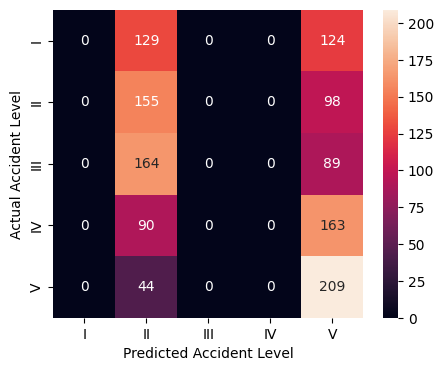


Confusion Matrix for Testing Data


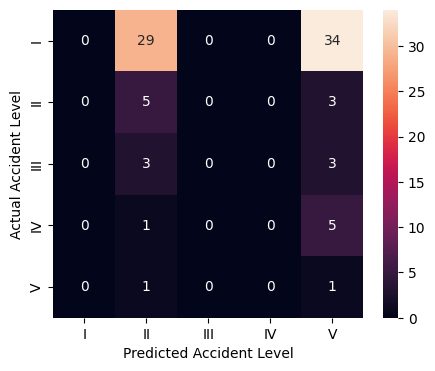

Classification Report for Training Data
              precision    recall  f1-score   support

           I       0.00      0.00      0.00       253
          II       0.27      0.61      0.37       253
         III       0.00      0.00      0.00       253
          IV       0.00      0.00      0.00       253
           V       0.31      0.83      0.45       253

    accuracy                           0.29      1265
   macro avg       0.11      0.29      0.16      1265
weighted avg       0.11      0.29      0.16      1265

Classification Report for Testing Data
              precision    recall  f1-score   support

           I       0.00      0.00      0.00        63
          II       0.13      0.62      0.21         8
         III       0.00      0.00      0.00         6
          IV       0.00      0.00      0.00         6
           V       0.02      0.50      0.04         2

    accuracy                           0.07        85
   macro avg       0.03      0.23      0.05        8

In [145]:
Execute_model(X_train_smote , y_train_smote, X_test, y_test, model='SVM')

**Using ADASYN to balance the data**

Confusion Matrix for Training Data


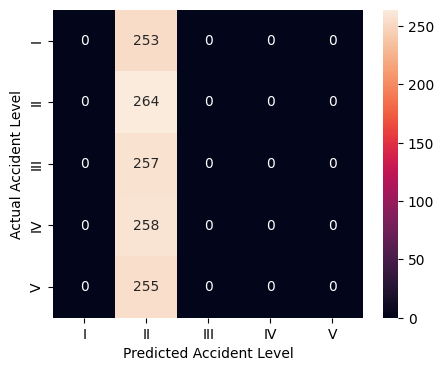


Confusion Matrix for Testing Data


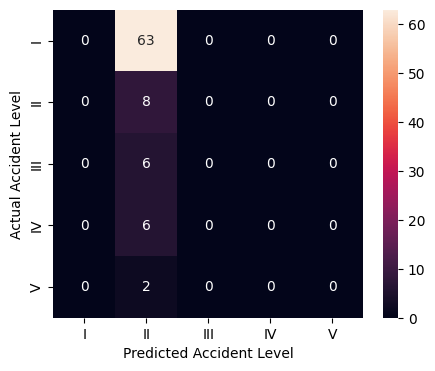

Classification Report for Training Data
              precision    recall  f1-score   support

           I       0.00      0.00      0.00       253
          II       0.21      1.00      0.34       264
         III       0.00      0.00      0.00       257
          IV       0.00      0.00      0.00       258
           V       0.00      0.00      0.00       255

    accuracy                           0.21      1287
   macro avg       0.04      0.20      0.07      1287
weighted avg       0.04      0.21      0.07      1287

Classification Report for Testing Data
              precision    recall  f1-score   support

           I       0.00      0.00      0.00        63
          II       0.09      1.00      0.17         8
         III       0.00      0.00      0.00         6
          IV       0.00      0.00      0.00         6
           V       0.00      0.00      0.00         2

    accuracy                           0.09        85
   macro avg       0.02      0.20      0.03        8

In [146]:
Execute_model(X_train_adasyn, y_train_adasyn, X_test, y_test, model='SVM')

**Observations**

The SVM model performs poorly on minority classes with the unbalanced data

When oversampling techniques were used the performance drastically reduced on even the majority class.

We have used SMOTE and ADASYN to balance the data


### **Logistic Regression  using Word2Vec**

We shall use these Word2Vec embeddings on a Logistic Regression model for 3 cases
- Unbalanced
-Oversampling with SMOTE
-Oversampling with ADASYN

**Unbalanced Data**

Confusion Matrix for Training Data


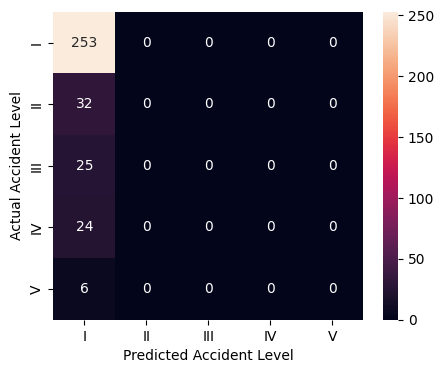


Confusion Matrix for Testing Data


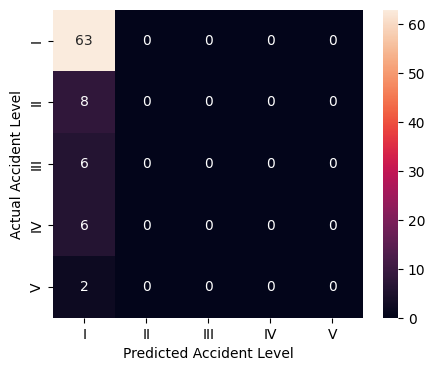

Classification Report for Training Data
              precision    recall  f1-score   support

           I       0.74      1.00      0.85       253
          II       0.00      0.00      0.00        32
         III       0.00      0.00      0.00        25
          IV       0.00      0.00      0.00        24
           V       0.00      0.00      0.00         6

    accuracy                           0.74       340
   macro avg       0.15      0.20      0.17       340
weighted avg       0.55      0.74      0.63       340

Classification Report for Testing Data
              precision    recall  f1-score   support

           I       0.74      1.00      0.85        63
          II       0.00      0.00      0.00         8
         III       0.00      0.00      0.00         6
          IV       0.00      0.00      0.00         6
           V       0.00      0.00      0.00         2

    accuracy                           0.74        85
   macro avg       0.15      0.20      0.17        8

In [147]:
Execute_model(X_train, y_train, X_test, y_test, model='LR')

**Using SMOTE to balance the data**

Confusion Matrix for Training Data


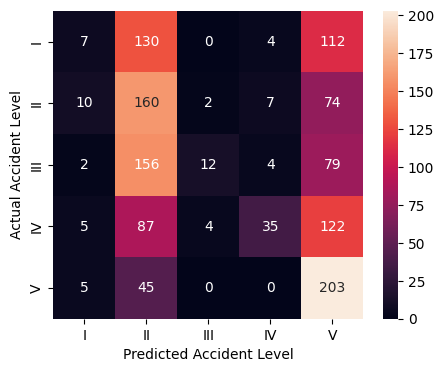


Confusion Matrix for Testing Data


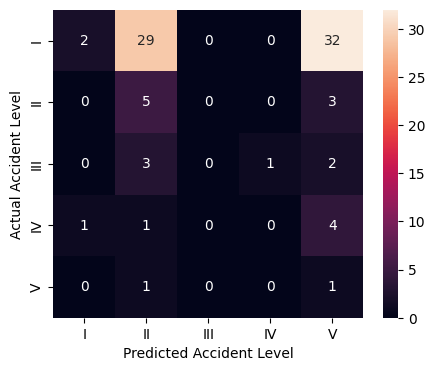

Classification Report for Training Data
              precision    recall  f1-score   support

           I       0.24      0.03      0.05       253
          II       0.28      0.63      0.39       253
         III       0.67      0.05      0.09       253
          IV       0.70      0.14      0.23       253
           V       0.34      0.80      0.48       253

    accuracy                           0.33      1265
   macro avg       0.45      0.33      0.25      1265
weighted avg       0.45      0.33      0.25      1265

Classification Report for Testing Data
              precision    recall  f1-score   support

           I       0.67      0.03      0.06        63
          II       0.13      0.62      0.21         8
         III       0.00      0.00      0.00         6
          IV       0.00      0.00      0.00         6
           V       0.02      0.50      0.05         2

    accuracy                           0.09        85
   macro avg       0.16      0.23      0.06        8

In [148]:
Execute_model(X_train_smote , y_train_smote, X_test, y_test, model='LR')

**Using ADASYN to balance the data**

Confusion Matrix for Training Data


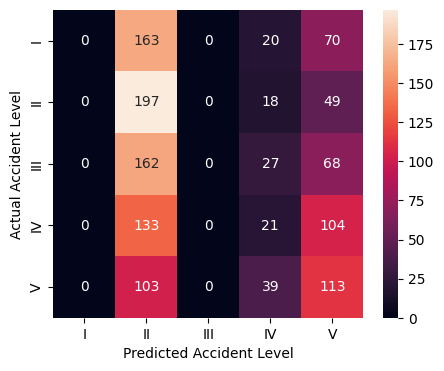


Confusion Matrix for Testing Data


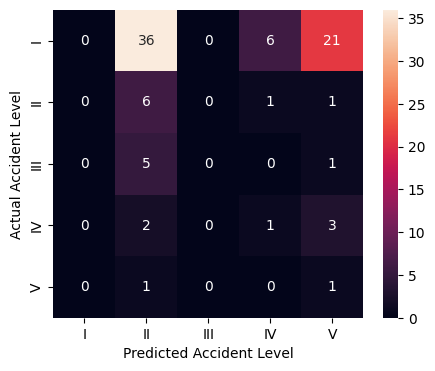

Classification Report for Training Data
              precision    recall  f1-score   support

           I       0.00      0.00      0.00       253
          II       0.26      0.75      0.39       264
         III       0.00      0.00      0.00       257
          IV       0.17      0.08      0.11       258
           V       0.28      0.44      0.34       255

    accuracy                           0.26      1287
   macro avg       0.14      0.25      0.17      1287
weighted avg       0.14      0.26      0.17      1287

Classification Report for Testing Data
              precision    recall  f1-score   support

           I       0.00      0.00      0.00        63
          II       0.12      0.75      0.21         8
         III       0.00      0.00      0.00         6
          IV       0.12      0.17      0.14         6
           V       0.04      0.50      0.07         2

    accuracy                           0.09        85
   macro avg       0.06      0.28      0.08        8

In [149]:
Execute_model(X_train_adasyn, y_train_adasyn, X_test, y_test, model='LR')

**Observations**

The Logistic Regression model also performs poorly on minority classes with the unbalanced data

When oversampling techniques were used the performance drastically reduced on even the majority class.

We have used SMOTE and ADASYN to balance the data

The performance of the model when oversampling using SMOTE and ADASYN is almost similar

### **XGBoost using Word2Vec**

We shall use these Word2Vec embeddings on XGBoost model for 3 cases
- Unbalanced
-Oversampling with SMOTE
-Oversampling with ADASYN

**Unbalanced Data**

Confusion Matrix for Training Data


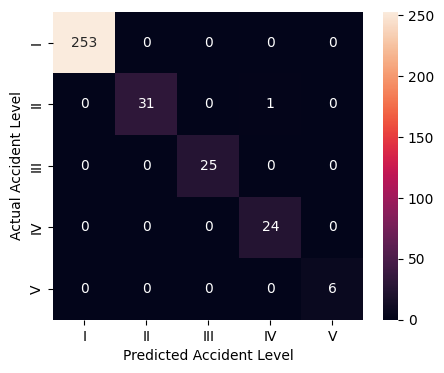


Confusion Matrix for Testing Data


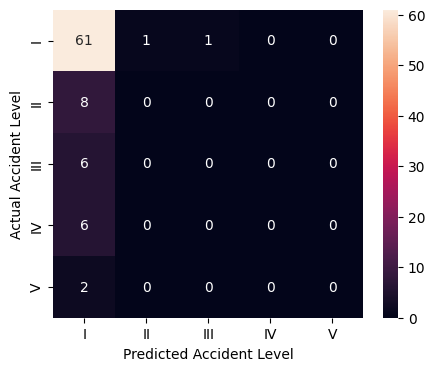

Classification Report for Training Data
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       253
           2       1.00      0.97      0.98        32
           3       1.00      1.00      1.00        25
           4       0.96      1.00      0.98        24
           5       1.00      1.00      1.00         6

    accuracy                           1.00       340
   macro avg       0.99      0.99      0.99       340
weighted avg       1.00      1.00      1.00       340

Classification Report for Testing Data
              precision    recall  f1-score   support

           1       0.73      0.97      0.84        63
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         2

    accuracy                           0.72        85
   macro avg       0.15      0.19      0.17        8

In [30]:
Execute_model(X_train, y_train, X_test, y_test, model='XGB')

**Using SMOTE to balance the data**

Confusion Matrix for Training Data


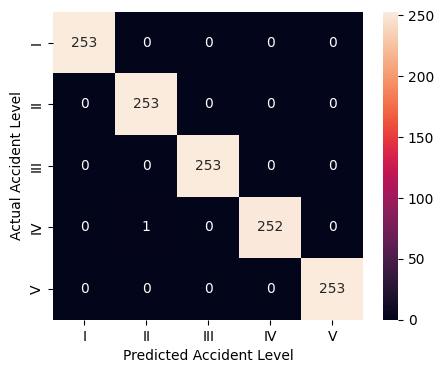


Confusion Matrix for Testing Data


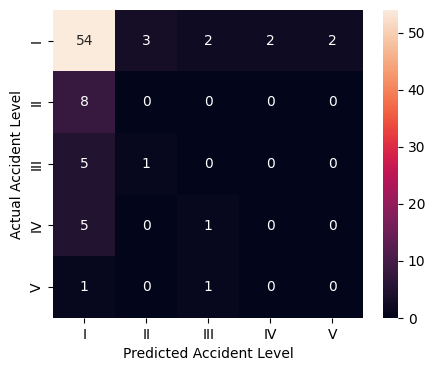

Classification Report for Training Data
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       253
           2       1.00      1.00      1.00       253
           3       1.00      1.00      1.00       253
           4       1.00      1.00      1.00       253
           5       1.00      1.00      1.00       253

    accuracy                           1.00      1265
   macro avg       1.00      1.00      1.00      1265
weighted avg       1.00      1.00      1.00      1265

Classification Report for Testing Data
              precision    recall  f1-score   support

           1       0.74      0.86      0.79        63
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         2

    accuracy                           0.64        85
   macro avg       0.15      0.17      0.16        8

In [31]:
Execute_model(X_train_smote , y_train_smote, X_test, y_test, model='XGB')

**Using ADASYN to balance the data**

Confusion Matrix for Training Data


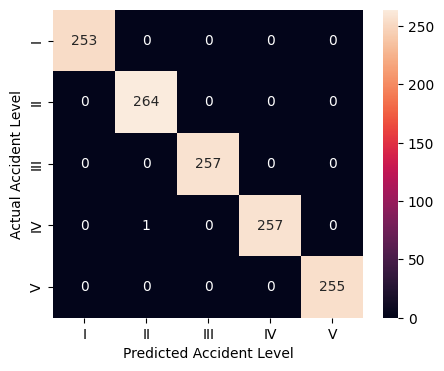


Confusion Matrix for Testing Data


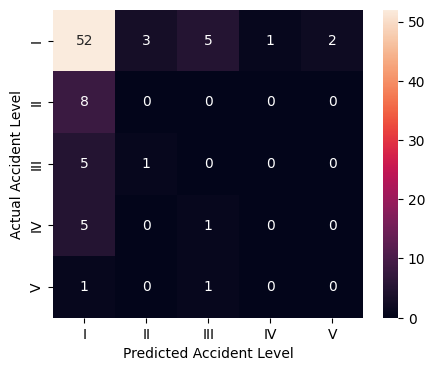

Classification Report for Training Data
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       253
           2       1.00      1.00      1.00       264
           3       1.00      1.00      1.00       257
           4       1.00      1.00      1.00       258
           5       1.00      1.00      1.00       255

    accuracy                           1.00      1287
   macro avg       1.00      1.00      1.00      1287
weighted avg       1.00      1.00      1.00      1287

Classification Report for Testing Data
              precision    recall  f1-score   support

           1       0.73      0.83      0.78        63
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         2

    accuracy                           0.61        85
   macro avg       0.15      0.17      0.16        8

In [32]:
Execute_model(X_train_adasyn, y_train_adasyn, X_test, y_test, model='XGB')

**Observations**

The XGBoost model is found to be overfitting in training data but performs poorly on minority classes in test with the unbalanced data

When oversampling techniques were used the performance on test data reduces marginally but the model continues to overfit the training data

We have used SMOTE and ADASYN to balance the data

The performance of the model when oversampling using SMOTE and ADASYN is almost similar

**Final observations - Word2Vec**

We have trained Random Forest, Logistic Regression, SVM and XGBoost using the Word2Vec encodings that we created.

To deal with the imbalanced data we have used both SMOTE and ADASYN to oversample the dataset


We shall similarly train the models with GloVe embeddings and do the necessary data balancing

## **TF-IDF Vectorizer**

In [39]:
# Using TfidfVectorizer to convert text data to numbers.
tfidfVectorizer = TfidfVectorizer(max_features=2000)
description_features = tfidfVectorizer.fit_transform(df['Cleaned_Description'])
description_features = description_features.toarray()
description_features.shape

(425, 1916)

In [54]:
# Storing independent variable
X = description_features

# Storing target variable
# y = df["Accident_Level"]
y = df["Accident_Level"].map({'I':1 , 'II':2, 'III':3, 'IV':4,'V':5})

X_train, X_test, y_train, y_test = train_test_split(X ,y, test_size = 0.20, random_state = 42, stratify = y)

X_train.shape,y_train.shape,X_test.shape, y_test.shape

((340, 1916), (340,), (85, 1916), (85,))

In [56]:
X_train_smote, y_train_smote = create_SMOTE_Xy(X_train, y_train)

Shape of Training and Test sets after SMOTE operation
(1265, 1916) (1265,) (85, 1916) (85,)


In [57]:
X_train_adasyn, y_train_adasyn = create_ADASYN_Xy(X_train, y_train)

Shape of Training and Test sets after ADASYN operation
(1270, 1916) (1270,) (85, 1916) (85,)


### **Random Forest using TF-IDF**

We shall use these TF-IDF Vectors on Random Forest Classifiers for 3 cases
- Unbalanced
-Oversampling with SMOTE
-Oversampling with ADASYN

**Unbalanced Data**

Confusion Matrix for Training Data


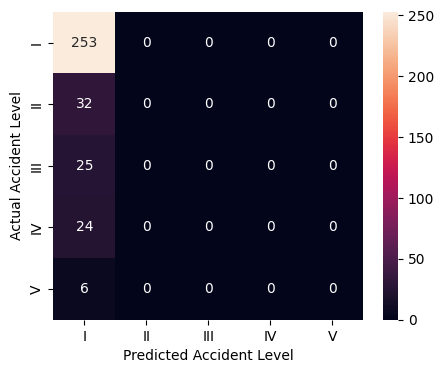


Confusion Matrix for Testing Data


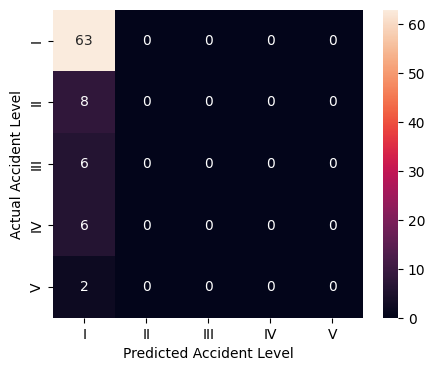

Classification Report for Training Data
              precision    recall  f1-score   support

           1       0.74      1.00      0.85       253
           2       0.00      0.00      0.00        32
           3       0.00      0.00      0.00        25
           4       0.00      0.00      0.00        24
           5       0.00      0.00      0.00         6

    accuracy                           0.74       340
   macro avg       0.15      0.20      0.17       340
weighted avg       0.55      0.74      0.63       340

Classification Report for Testing Data
              precision    recall  f1-score   support

           1       0.74      1.00      0.85        63
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         2

    accuracy                           0.74        85
   macro avg       0.15      0.20      0.17        8

In [60]:
Execute_model(X_train, y_train, X_test, y_test, model='RFC')

**Observations**

It is evident that the model performs poorly on minority classes owing to lack of adequate training data because of the highly imbalanced dataset.

We shall try some oversampling techniques to fix this problem.

**Using SMOTE to balance the data**

Confusion Matrix for Training Data


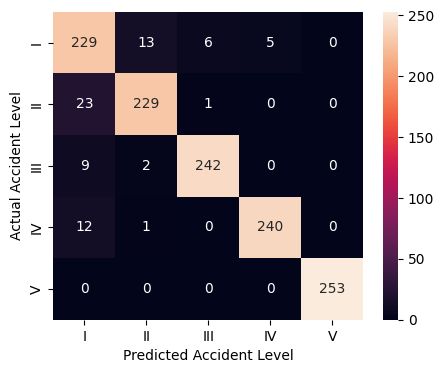


Confusion Matrix for Testing Data


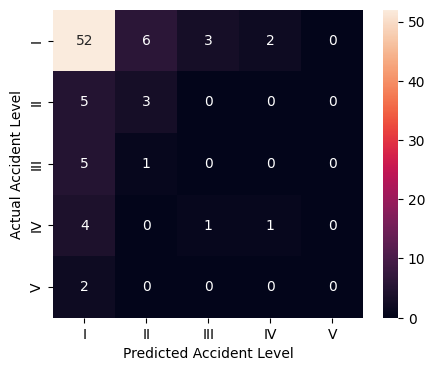

Classification Report for Training Data
              precision    recall  f1-score   support

           1       0.84      0.91      0.87       253
           2       0.93      0.91      0.92       253
           3       0.97      0.96      0.96       253
           4       0.98      0.95      0.96       253
           5       1.00      1.00      1.00       253

    accuracy                           0.94      1265
   macro avg       0.95      0.94      0.94      1265
weighted avg       0.95      0.94      0.94      1265

Classification Report for Testing Data
              precision    recall  f1-score   support

           1       0.76      0.83      0.79        63
           2       0.30      0.38      0.33         8
           3       0.00      0.00      0.00         6
           4       0.33      0.17      0.22         6
           5       0.00      0.00      0.00         2

    accuracy                           0.66        85
   macro avg       0.28      0.27      0.27        8

In [61]:
Execute_model(X_train_smote , y_train_smote, X_test, y_test, model='RFC')

**Observations**

We have used SMOTE to balance the data

The model overfits on training data but performance reduces on testing data

The performance on minority classes is still lacking

**Using ADASYN to balance the data**

Confusion Matrix for Training Data


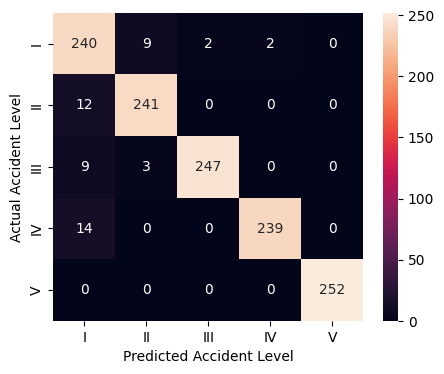


Confusion Matrix for Testing Data


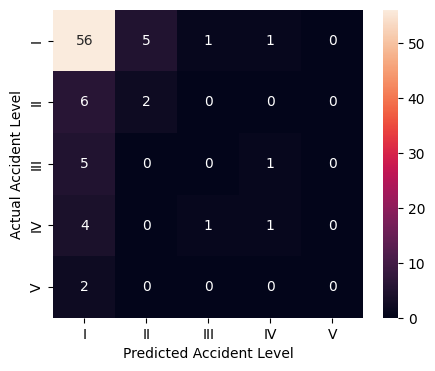

Classification Report for Training Data
              precision    recall  f1-score   support

           1       0.87      0.95      0.91       253
           2       0.95      0.95      0.95       253
           3       0.99      0.95      0.97       259
           4       0.99      0.94      0.97       253
           5       1.00      1.00      1.00       252

    accuracy                           0.96      1270
   macro avg       0.96      0.96      0.96      1270
weighted avg       0.96      0.96      0.96      1270

Classification Report for Testing Data
              precision    recall  f1-score   support

           1       0.77      0.89      0.82        63
           2       0.29      0.25      0.27         8
           3       0.00      0.00      0.00         6
           4       0.33      0.17      0.22         6
           5       0.00      0.00      0.00         2

    accuracy                           0.69        85
   macro avg       0.28      0.26      0.26        8

In [62]:
Execute_model(X_train_adasyn, y_train_adasyn, X_test, y_test, model='RFC')

**Observations**

We have used ADASYN to balance the data in this case

The model overfits on training data but even though the performance is reduced on testing data it still produces almost 70% test accuracy

The performance on minority classes is still a bit low in all cases

The performance of the model when oversampling using SMOTE and ADASYN is almost similar

### **SVM using TF-IDF**

We shall use these TFIDF vectors on Support Vector Classifiers for 3 cases
- Unbalanced
-Oversampling with SMOTE
-Oversampling with ADASYN

**Unbalanced Data**

Confusion Matrix for Training Data


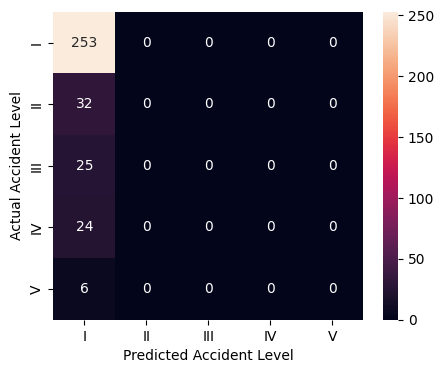


Confusion Matrix for Testing Data


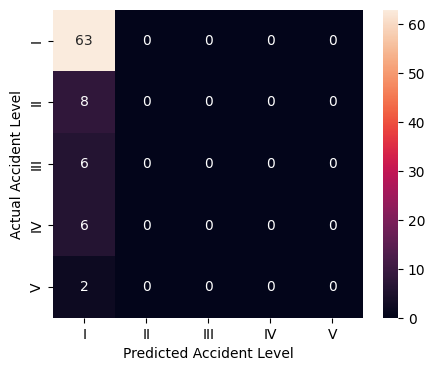

Classification Report for Training Data
              precision    recall  f1-score   support

           1       0.74      1.00      0.85       253
           2       0.00      0.00      0.00        32
           3       0.00      0.00      0.00        25
           4       0.00      0.00      0.00        24
           5       0.00      0.00      0.00         6

    accuracy                           0.74       340
   macro avg       0.15      0.20      0.17       340
weighted avg       0.55      0.74      0.63       340

Classification Report for Testing Data
              precision    recall  f1-score   support

           1       0.74      1.00      0.85        63
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         2

    accuracy                           0.74        85
   macro avg       0.15      0.20      0.17        8

In [63]:
Execute_model(X_train, y_train, X_test, y_test, model='SVM')

**Using SMOTE to balance the data**

Confusion Matrix for Training Data


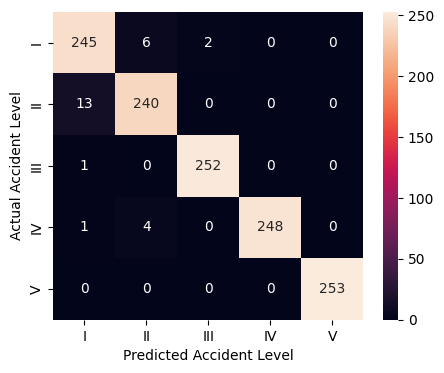


Confusion Matrix for Testing Data


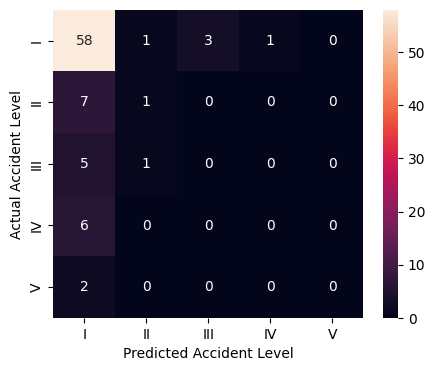

Classification Report for Training Data
              precision    recall  f1-score   support

           1       0.94      0.97      0.96       253
           2       0.96      0.95      0.95       253
           3       0.99      1.00      0.99       253
           4       1.00      0.98      0.99       253
           5       1.00      1.00      1.00       253

    accuracy                           0.98      1265
   macro avg       0.98      0.98      0.98      1265
weighted avg       0.98      0.98      0.98      1265

Classification Report for Testing Data
              precision    recall  f1-score   support

           1       0.74      0.92      0.82        63
           2       0.33      0.12      0.18         8
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         2

    accuracy                           0.69        85
   macro avg       0.22      0.21      0.20        8

In [64]:
Execute_model(X_train_smote , y_train_smote, X_test, y_test, model='SVM')

**Using ADASYN to balance the data**

Confusion Matrix for Training Data


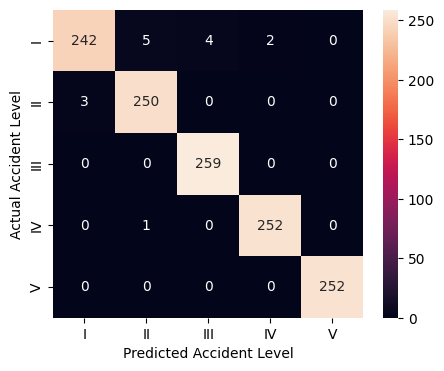


Confusion Matrix for Testing Data


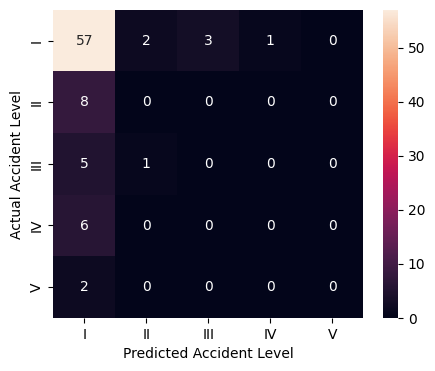

Classification Report for Training Data
              precision    recall  f1-score   support

           1       0.99      0.96      0.97       253
           2       0.98      0.99      0.98       253
           3       0.98      1.00      0.99       259
           4       0.99      1.00      0.99       253
           5       1.00      1.00      1.00       252

    accuracy                           0.99      1270
   macro avg       0.99      0.99      0.99      1270
weighted avg       0.99      0.99      0.99      1270

Classification Report for Testing Data
              precision    recall  f1-score   support

           1       0.73      0.90      0.81        63
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         2

    accuracy                           0.67        85
   macro avg       0.15      0.18      0.16        8

In [65]:
Execute_model(X_train_adasyn, y_train_adasyn, X_test, y_test, model='SVM')

**Observations**

The SVM model performs poorly on minority classes with the unbalanced data

When oversampling techniques were used the performance drastically reduced on even the majority class.

We have used SMOTE and ADASYN to balance the data


### **Logistic Regression using TF-IDF**

We shall use these TF-IDF vectors on a Logistic Regression model for 3 cases
- Unbalanced
-Oversampling with SMOTE
-Oversampling with ADASYN

**Unbalanced Data**

Confusion Matrix for Training Data


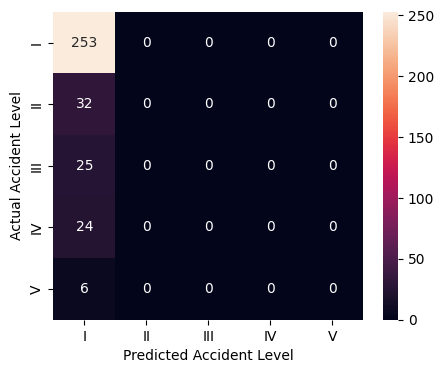


Confusion Matrix for Testing Data


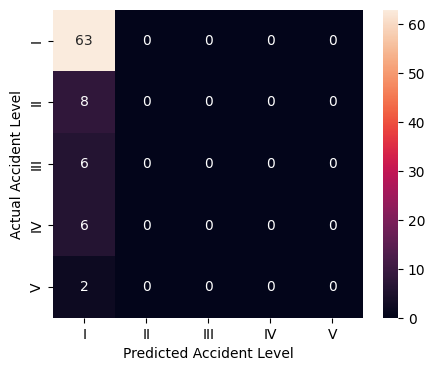

Classification Report for Training Data
              precision    recall  f1-score   support

           1       0.74      1.00      0.85       253
           2       0.00      0.00      0.00        32
           3       0.00      0.00      0.00        25
           4       0.00      0.00      0.00        24
           5       0.00      0.00      0.00         6

    accuracy                           0.74       340
   macro avg       0.15      0.20      0.17       340
weighted avg       0.55      0.74      0.63       340

Classification Report for Testing Data
              precision    recall  f1-score   support

           1       0.74      1.00      0.85        63
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         2

    accuracy                           0.74        85
   macro avg       0.15      0.20      0.17        8

In [69]:
Execute_model(X_train, y_train, X_test, y_test, model='LR')

**Using SMOTE to balance the data**

Confusion Matrix for Training Data


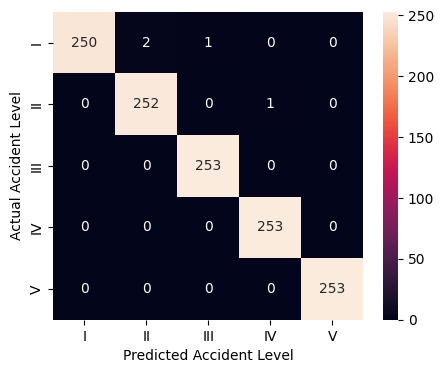


Confusion Matrix for Testing Data


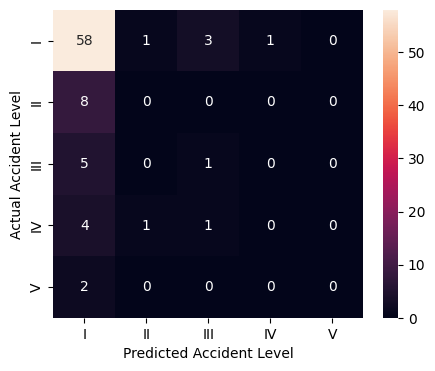

Classification Report for Training Data
              precision    recall  f1-score   support

           1       1.00      0.99      0.99       253
           2       0.99      1.00      0.99       253
           3       1.00      1.00      1.00       253
           4       1.00      1.00      1.00       253
           5       1.00      1.00      1.00       253

    accuracy                           1.00      1265
   macro avg       1.00      1.00      1.00      1265
weighted avg       1.00      1.00      1.00      1265

Classification Report for Testing Data
              precision    recall  f1-score   support

           1       0.75      0.92      0.83        63
           2       0.00      0.00      0.00         8
           3       0.20      0.17      0.18         6
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         2

    accuracy                           0.69        85
   macro avg       0.19      0.22      0.20        8

In [70]:
Execute_model(X_train_smote , y_train_smote, X_test, y_test, model='LR')

**Using ADASYN to balance the data**

Confusion Matrix for Training Data


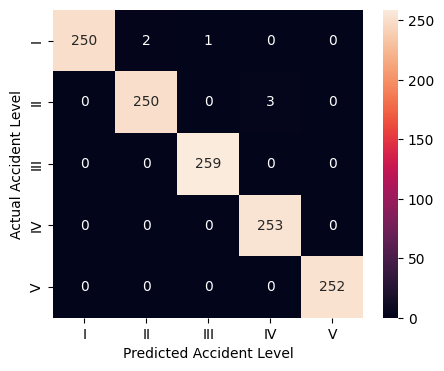


Confusion Matrix for Testing Data


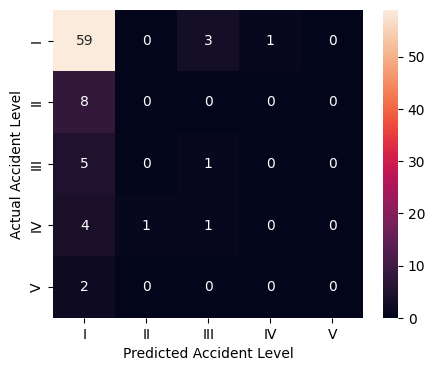

Classification Report for Training Data
              precision    recall  f1-score   support

           1       1.00      0.99      0.99       253
           2       0.99      0.99      0.99       253
           3       1.00      1.00      1.00       259
           4       0.99      1.00      0.99       253
           5       1.00      1.00      1.00       252

    accuracy                           1.00      1270
   macro avg       1.00      1.00      1.00      1270
weighted avg       1.00      1.00      1.00      1270

Classification Report for Testing Data
              precision    recall  f1-score   support

           1       0.76      0.94      0.84        63
           2       0.00      0.00      0.00         8
           3       0.20      0.17      0.18         6
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         2

    accuracy                           0.71        85
   macro avg       0.19      0.22      0.20        8

In [71]:
Execute_model(X_train_adasyn, y_train_adasyn, X_test, y_test, model='LR')

**Observations**

The Logistic Regression model also performs poorly on minority classes with the unbalanced data

When oversampling techniques were used the performance drastically reduced on even the majority class.

We have used SMOTE and ADASYN to balance the data

The performance of the model when oversampling using SMOTE and ADASYN is almost similar

### **XGBoost using TF-IDF**

We shall use these TF-IDF Vectors on XGBoost model for 3 cases
- Unbalanced
-Oversampling with SMOTE
-Oversampling with ADASYN

**Unbalanced Data**

Confusion Matrix for Training Data


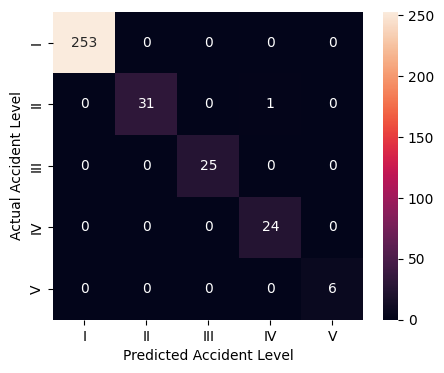


Confusion Matrix for Testing Data


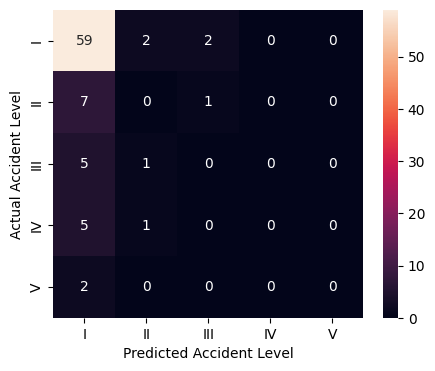

Classification Report for Training Data
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       253
           2       1.00      0.97      0.98        32
           3       1.00      1.00      1.00        25
           4       0.96      1.00      0.98        24
           5       1.00      1.00      1.00         6

    accuracy                           1.00       340
   macro avg       0.99      0.99      0.99       340
weighted avg       1.00      1.00      1.00       340

Classification Report for Testing Data
              precision    recall  f1-score   support

           1       0.76      0.94      0.84        63
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         2

    accuracy                           0.69        85
   macro avg       0.15      0.19      0.17        8

In [66]:
Execute_model(X_train, y_train, X_test, y_test, model='XGB')

**Using SMOTE to balance the data**

Confusion Matrix for Training Data


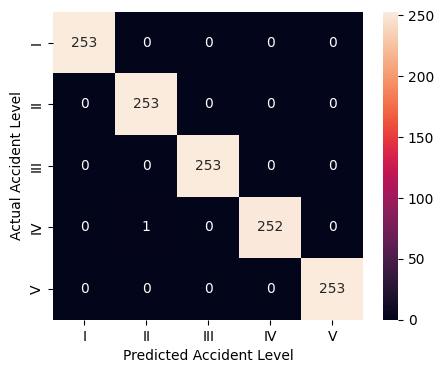


Confusion Matrix for Testing Data


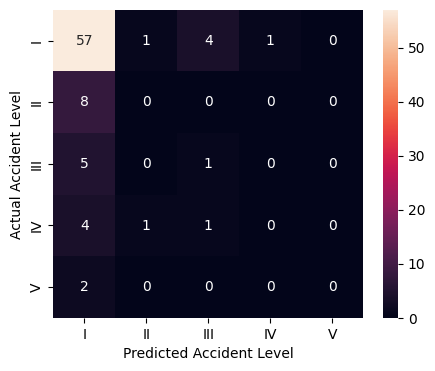

Classification Report for Training Data
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       253
           2       1.00      1.00      1.00       253
           3       1.00      1.00      1.00       253
           4       1.00      1.00      1.00       253
           5       1.00      1.00      1.00       253

    accuracy                           1.00      1265
   macro avg       1.00      1.00      1.00      1265
weighted avg       1.00      1.00      1.00      1265

Classification Report for Testing Data
              precision    recall  f1-score   support

           1       0.75      0.90      0.82        63
           2       0.00      0.00      0.00         8
           3       0.17      0.17      0.17         6
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         2

    accuracy                           0.68        85
   macro avg       0.18      0.21      0.20        8

In [67]:
Execute_model(X_train_smote , y_train_smote, X_test, y_test, model='XGB')

**Using ADASYN to balance the data**

Confusion Matrix for Training Data


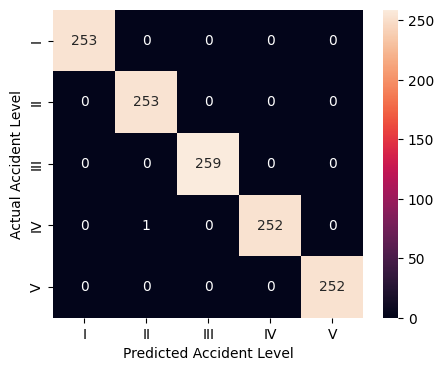


Confusion Matrix for Testing Data


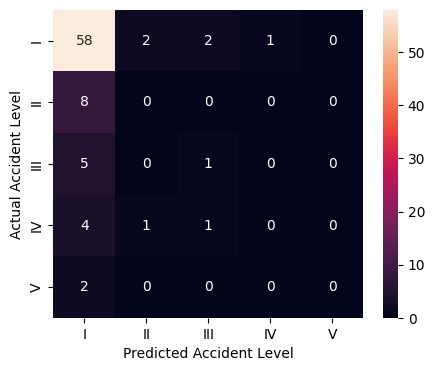

Classification Report for Training Data
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       253
           2       1.00      1.00      1.00       253
           3       1.00      1.00      1.00       259
           4       1.00      1.00      1.00       253
           5       1.00      1.00      1.00       252

    accuracy                           1.00      1270
   macro avg       1.00      1.00      1.00      1270
weighted avg       1.00      1.00      1.00      1270

Classification Report for Testing Data
              precision    recall  f1-score   support

           1       0.75      0.92      0.83        63
           2       0.00      0.00      0.00         8
           3       0.25      0.17      0.20         6
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         2

    accuracy                           0.69        85
   macro avg       0.20      0.22      0.21        8

In [68]:
Execute_model(X_train_adasyn, y_train_adasyn, X_test, y_test, model='XGB')

**Observations**

The XGBoost model is found to be overfitting in training data but performs poorly on minority classes in test with the unbalanced data

When oversampling techniques were used the performance on test data reduces marginally but the model continues to overfit the training data

We have used SMOTE and ADASYN to balance the data

The performance of the model when oversampling using SMOTE and ADASYN is almost similar

**Final observations - TF-IDF**

We have trained Random Forest, Logistic Regression, SVM and XGBoost using the TF-IDF Vectors that were created.

To deal with the imbalanced data we have used both SMOTE and ADASYN to oversample the dataset


## **GloVe Embeddings**